### Course - CS-513 Knowledge Discovery and Data Mining
#### Problem Statement - Predict the prices of real estate in New York City using the dataset from Kaggle

In [1]:
# Import required libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv('nyc-rolling-sales.csv')

# Dataset columns pre-cleanup
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

In [3]:
# Clean dataset

# Drop unnamed serial name column which does not seem to give significant information
df.drop('Unnamed: 0', axis=1, inplace=True)

# Check and drop columns where all cells are empty or -
df = df.applymap(lambda x: pd.NA if str(x).strip() in ['-', ''] else x)
df.dropna(axis=1, how='all', inplace=True)

# Dataset columns post-cleanup
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            83810 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   BUILDING CLASS AT PRESENT       83810 non-null  object
 7   ADDRESS                         84548 non-null  object
 8   APARTMENT NUMBER                19052 non-null  object
 9   ZIP CODE                        84548 non-null  int64 
 10  RESIDENTIAL UNITS               84548 non-null  int64 
 11  COMMERCIAL UNITS                84548 non-null  int64 
 12  TOTAL UNITS                     84548 non-null

In [4]:
# View dataset statistics

print('(Rows, Columns):', df.shape)
df.head()


(Rows, Columns): (84548, 20)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,<NA>,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,234 EAST 4TH STREET,<NA>,10009,28,3,31,4616,18690,1900,2,C7,<NA>,2016-12-14 00:00:00
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,197 EAST 3RD STREET,<NA>,10009,16,1,17,2212,7803,1900,2,C7,<NA>,2016-12-09 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,<NA>,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,<NA>,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [5]:
# Check data type of features
print('Data type of features', df.dtypes)

Data type of features BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object


In [6]:
# Find categorical columns - columns with less than 10 unique values considered cateogrical for the purpose

categorical_columns = []

for column in df.columns:
    if df[column].dtype == 'object' or df[column].nunique() < 10:
        categorical_columns.append(column)


print('Categorical columns:')
print(categorical_columns, '\n')

Categorical columns:
['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE', 'SALE DATE'] 



In [7]:
# Filter out categorical features from 'categorical_columns' if they are truly useful in categorical sense
categorical_columns = ['BOROUGH', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE']

for col in categorical_columns:
    df[col] = df[col].astype('category')

# Convert other feature types as and where required
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')

In [8]:
# Check if all features are appropriately set as per thier data types
print('Data type of features:')
df.dtypes

Data type of features:


BOROUGH                                 category
NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                 category
TAX CLASS AT PRESENT                    category
BLOCK                                      int64
LOT                                        int64
BUILDING CLASS AT PRESENT               category
ADDRESS                                   object
APARTMENT NUMBER                          object
ZIP CODE                                   int64
RESIDENTIAL UNITS                          int64
COMMERCIAL UNITS                           int64
TOTAL UNITS                                int64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                                 int64
TAX CLASS AT TIME OF SALE               category
BUILDING CLASS AT TIME OF SALE          category
SALE PRICE                               float64
SALE DATE                         datetime64[ns]
dtype: object

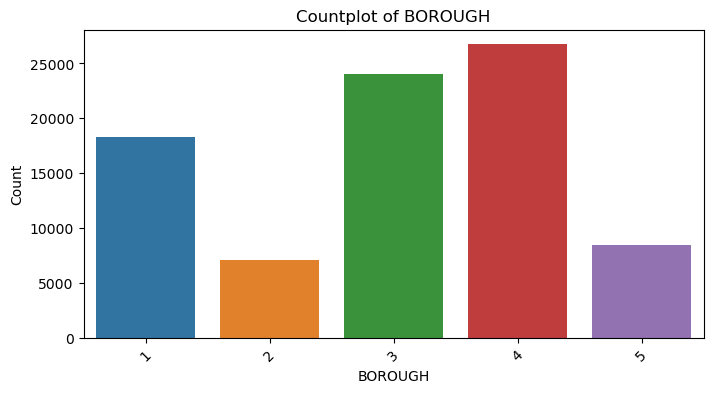

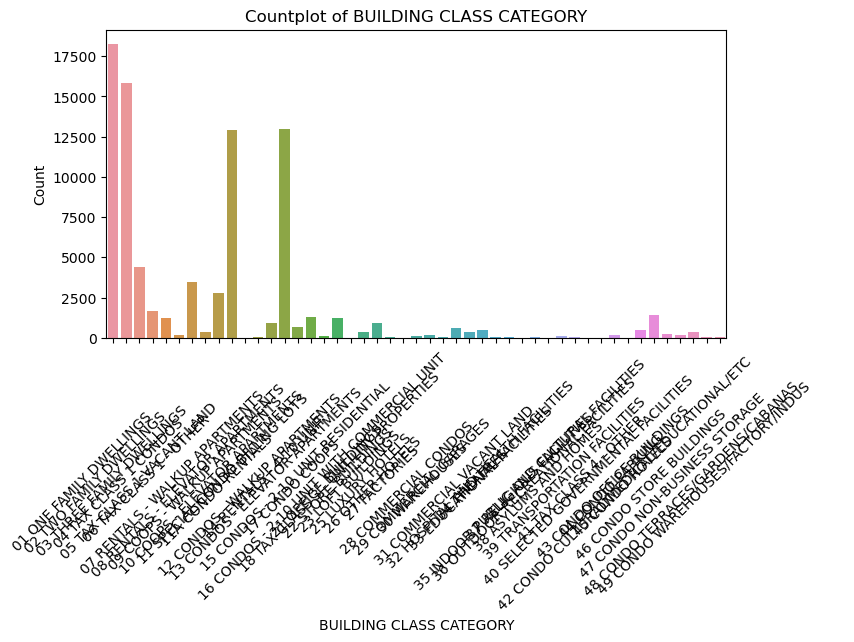

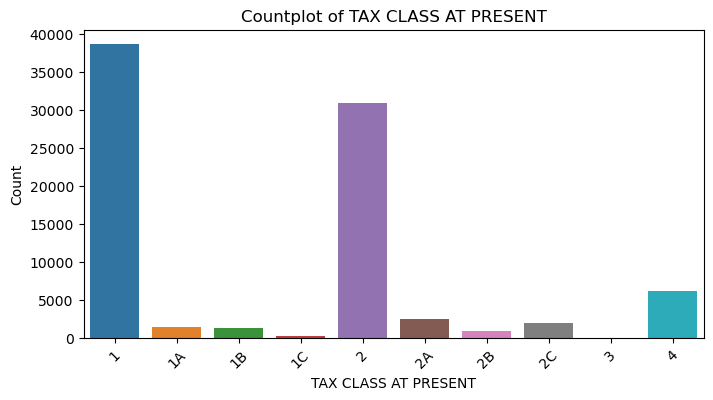

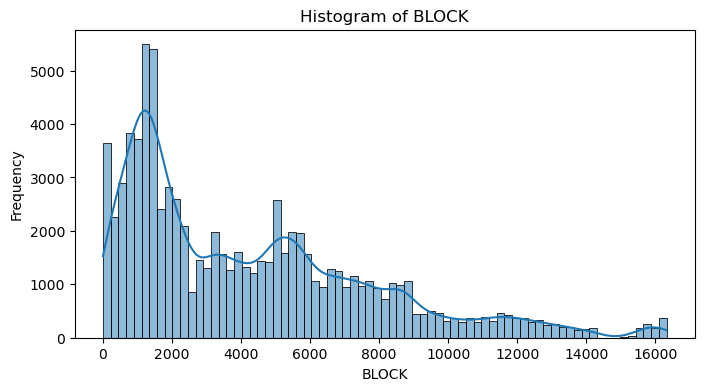

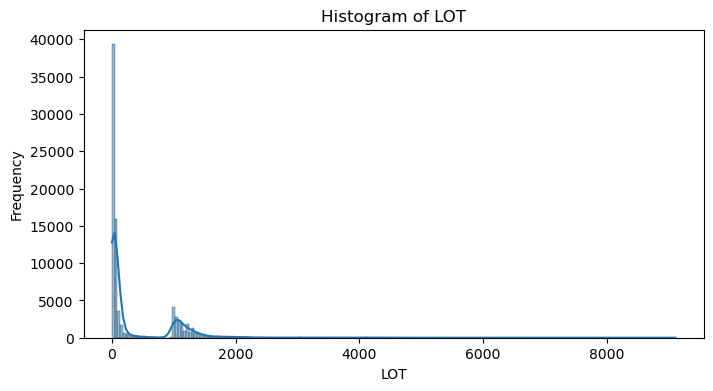

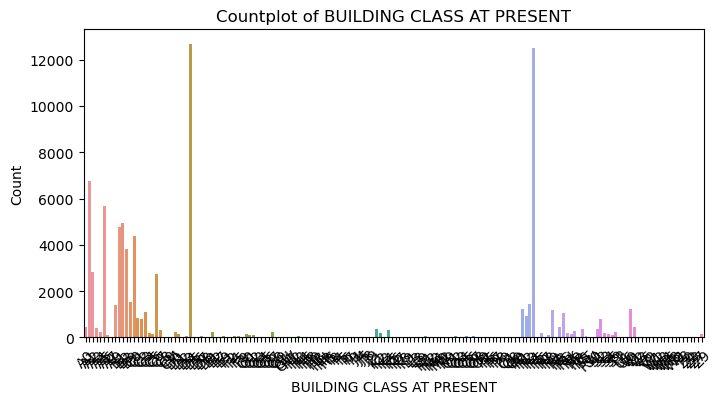

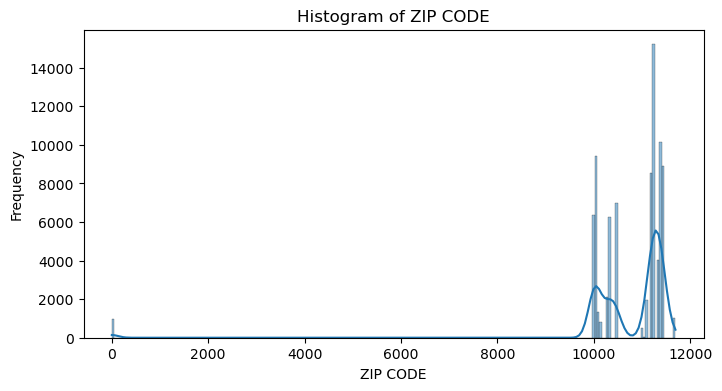

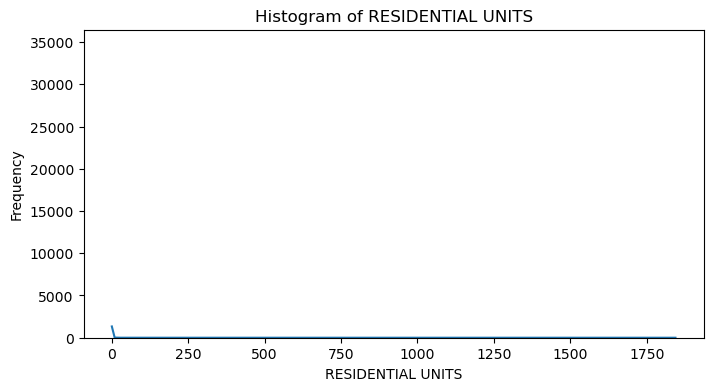

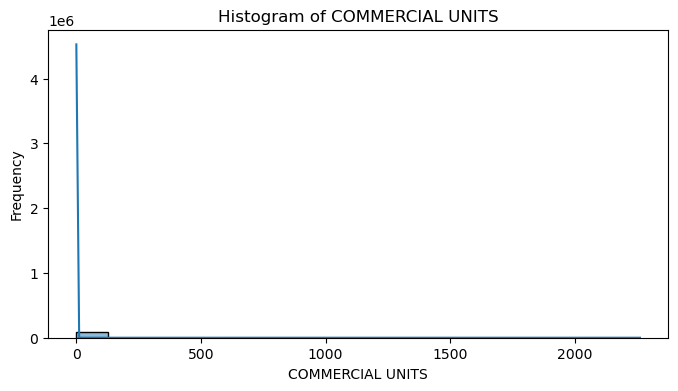

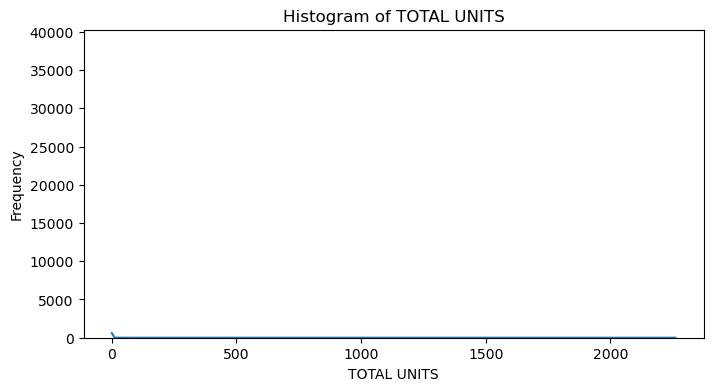

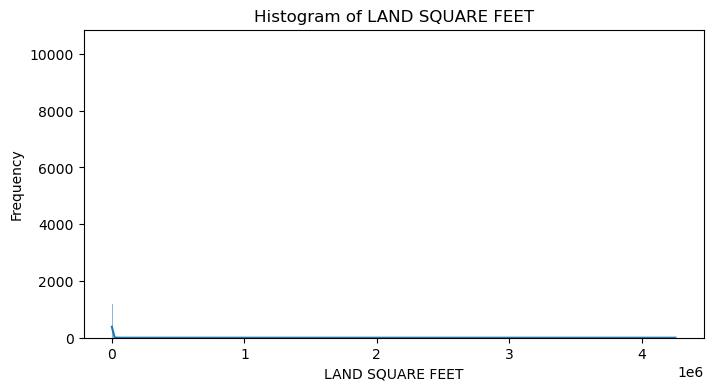

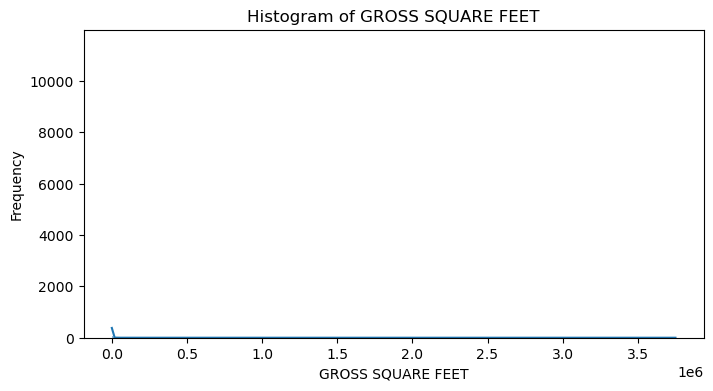

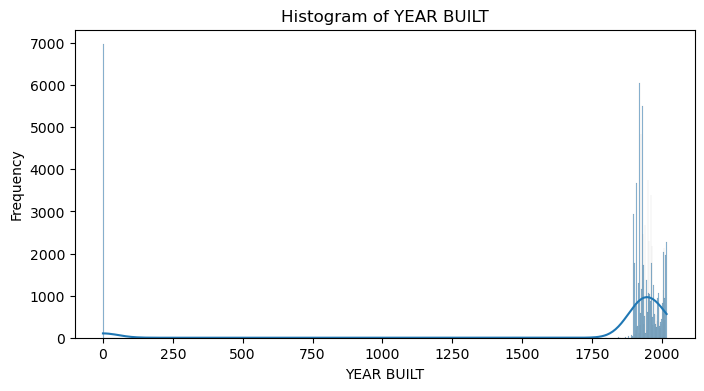

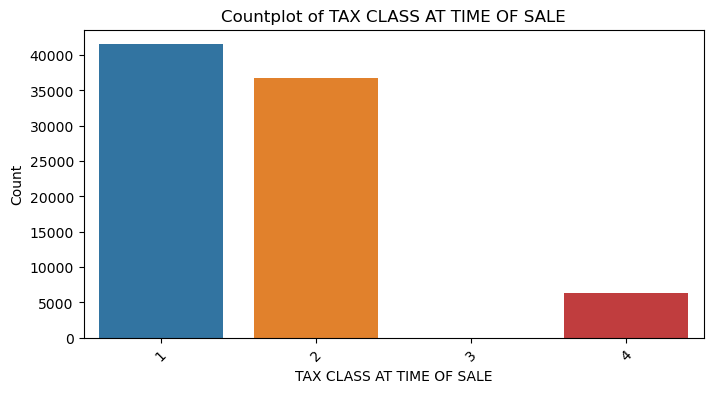

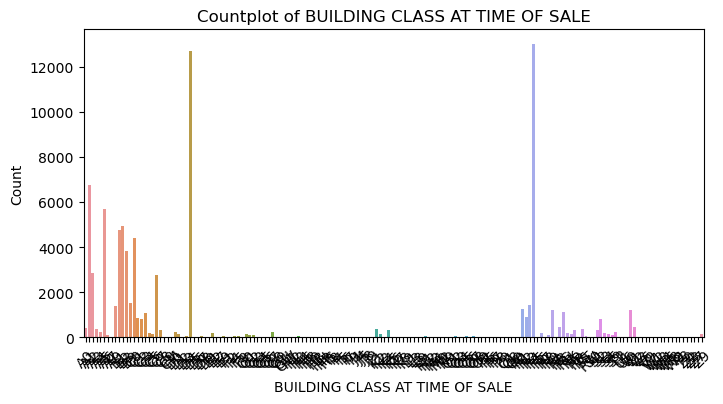

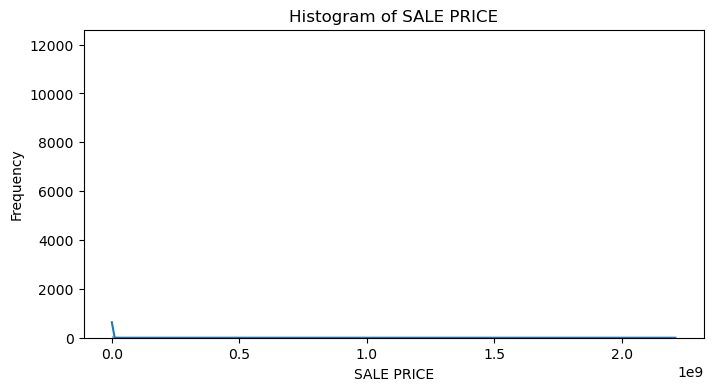

In [9]:
# Plot histogram for numerical data
for column in df.columns:
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(df[column]):
        # Plot a histogram for numeric data
        plt.figure(figsize=(8, 4))
        sns.histplot(df[column], kde=True)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

    # Check if the column is categorical
    elif pd.api.types.is_categorical_dtype(df[column]):
        # Plot a countplot for categorical data
        plt.figure(figsize=(8, 4))
        sns.countplot(x=column, data=df)
        plt.title(f'Countplot of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

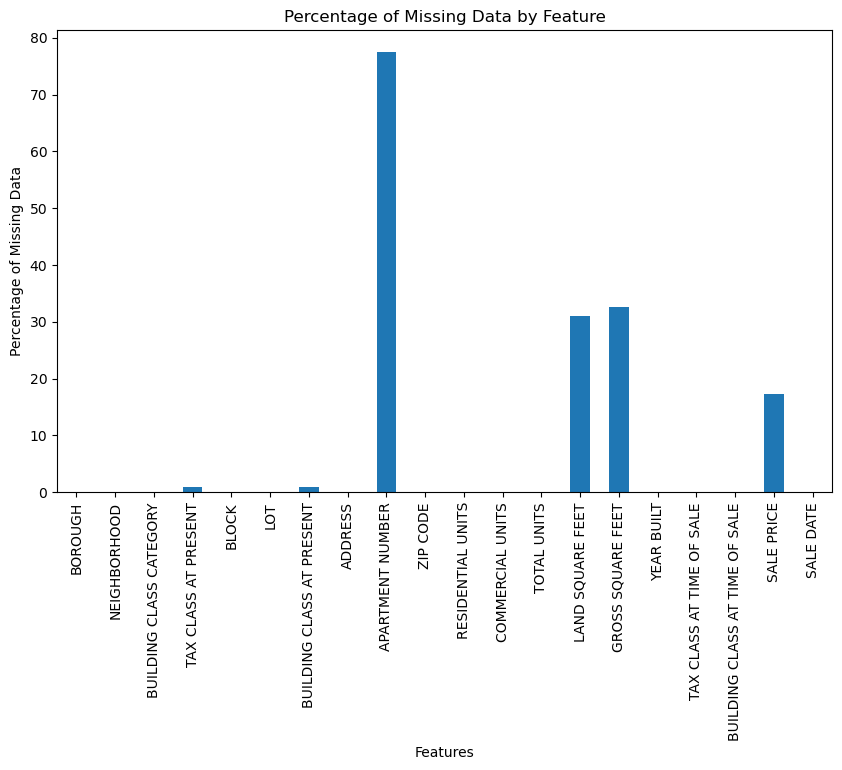

In [10]:
# Missing data - understand percentage of missing data

# Calculate the percentage of missing data in each column
missing_percentage = df.isnull().mean() * 100

# Create a bar plot
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar')
plt.ylabel('Percentage of Missing Data')
plt.xlabel('Features')
plt.title('Percentage of Missing Data by Feature')

# Show the plot
plt.show()

In [11]:
df.dtypes

BOROUGH                                 category
NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                 category
TAX CLASS AT PRESENT                    category
BLOCK                                      int64
LOT                                        int64
BUILDING CLASS AT PRESENT               category
ADDRESS                                   object
APARTMENT NUMBER                          object
ZIP CODE                                   int64
RESIDENTIAL UNITS                          int64
COMMERCIAL UNITS                           int64
TOTAL UNITS                                int64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                                 int64
TAX CLASS AT TIME OF SALE               category
BUILDING CLASS AT TIME OF SALE          category
SALE PRICE                               float64
SALE DATE                         datetime64[ns]
dtype: object

/Users/poojamule/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


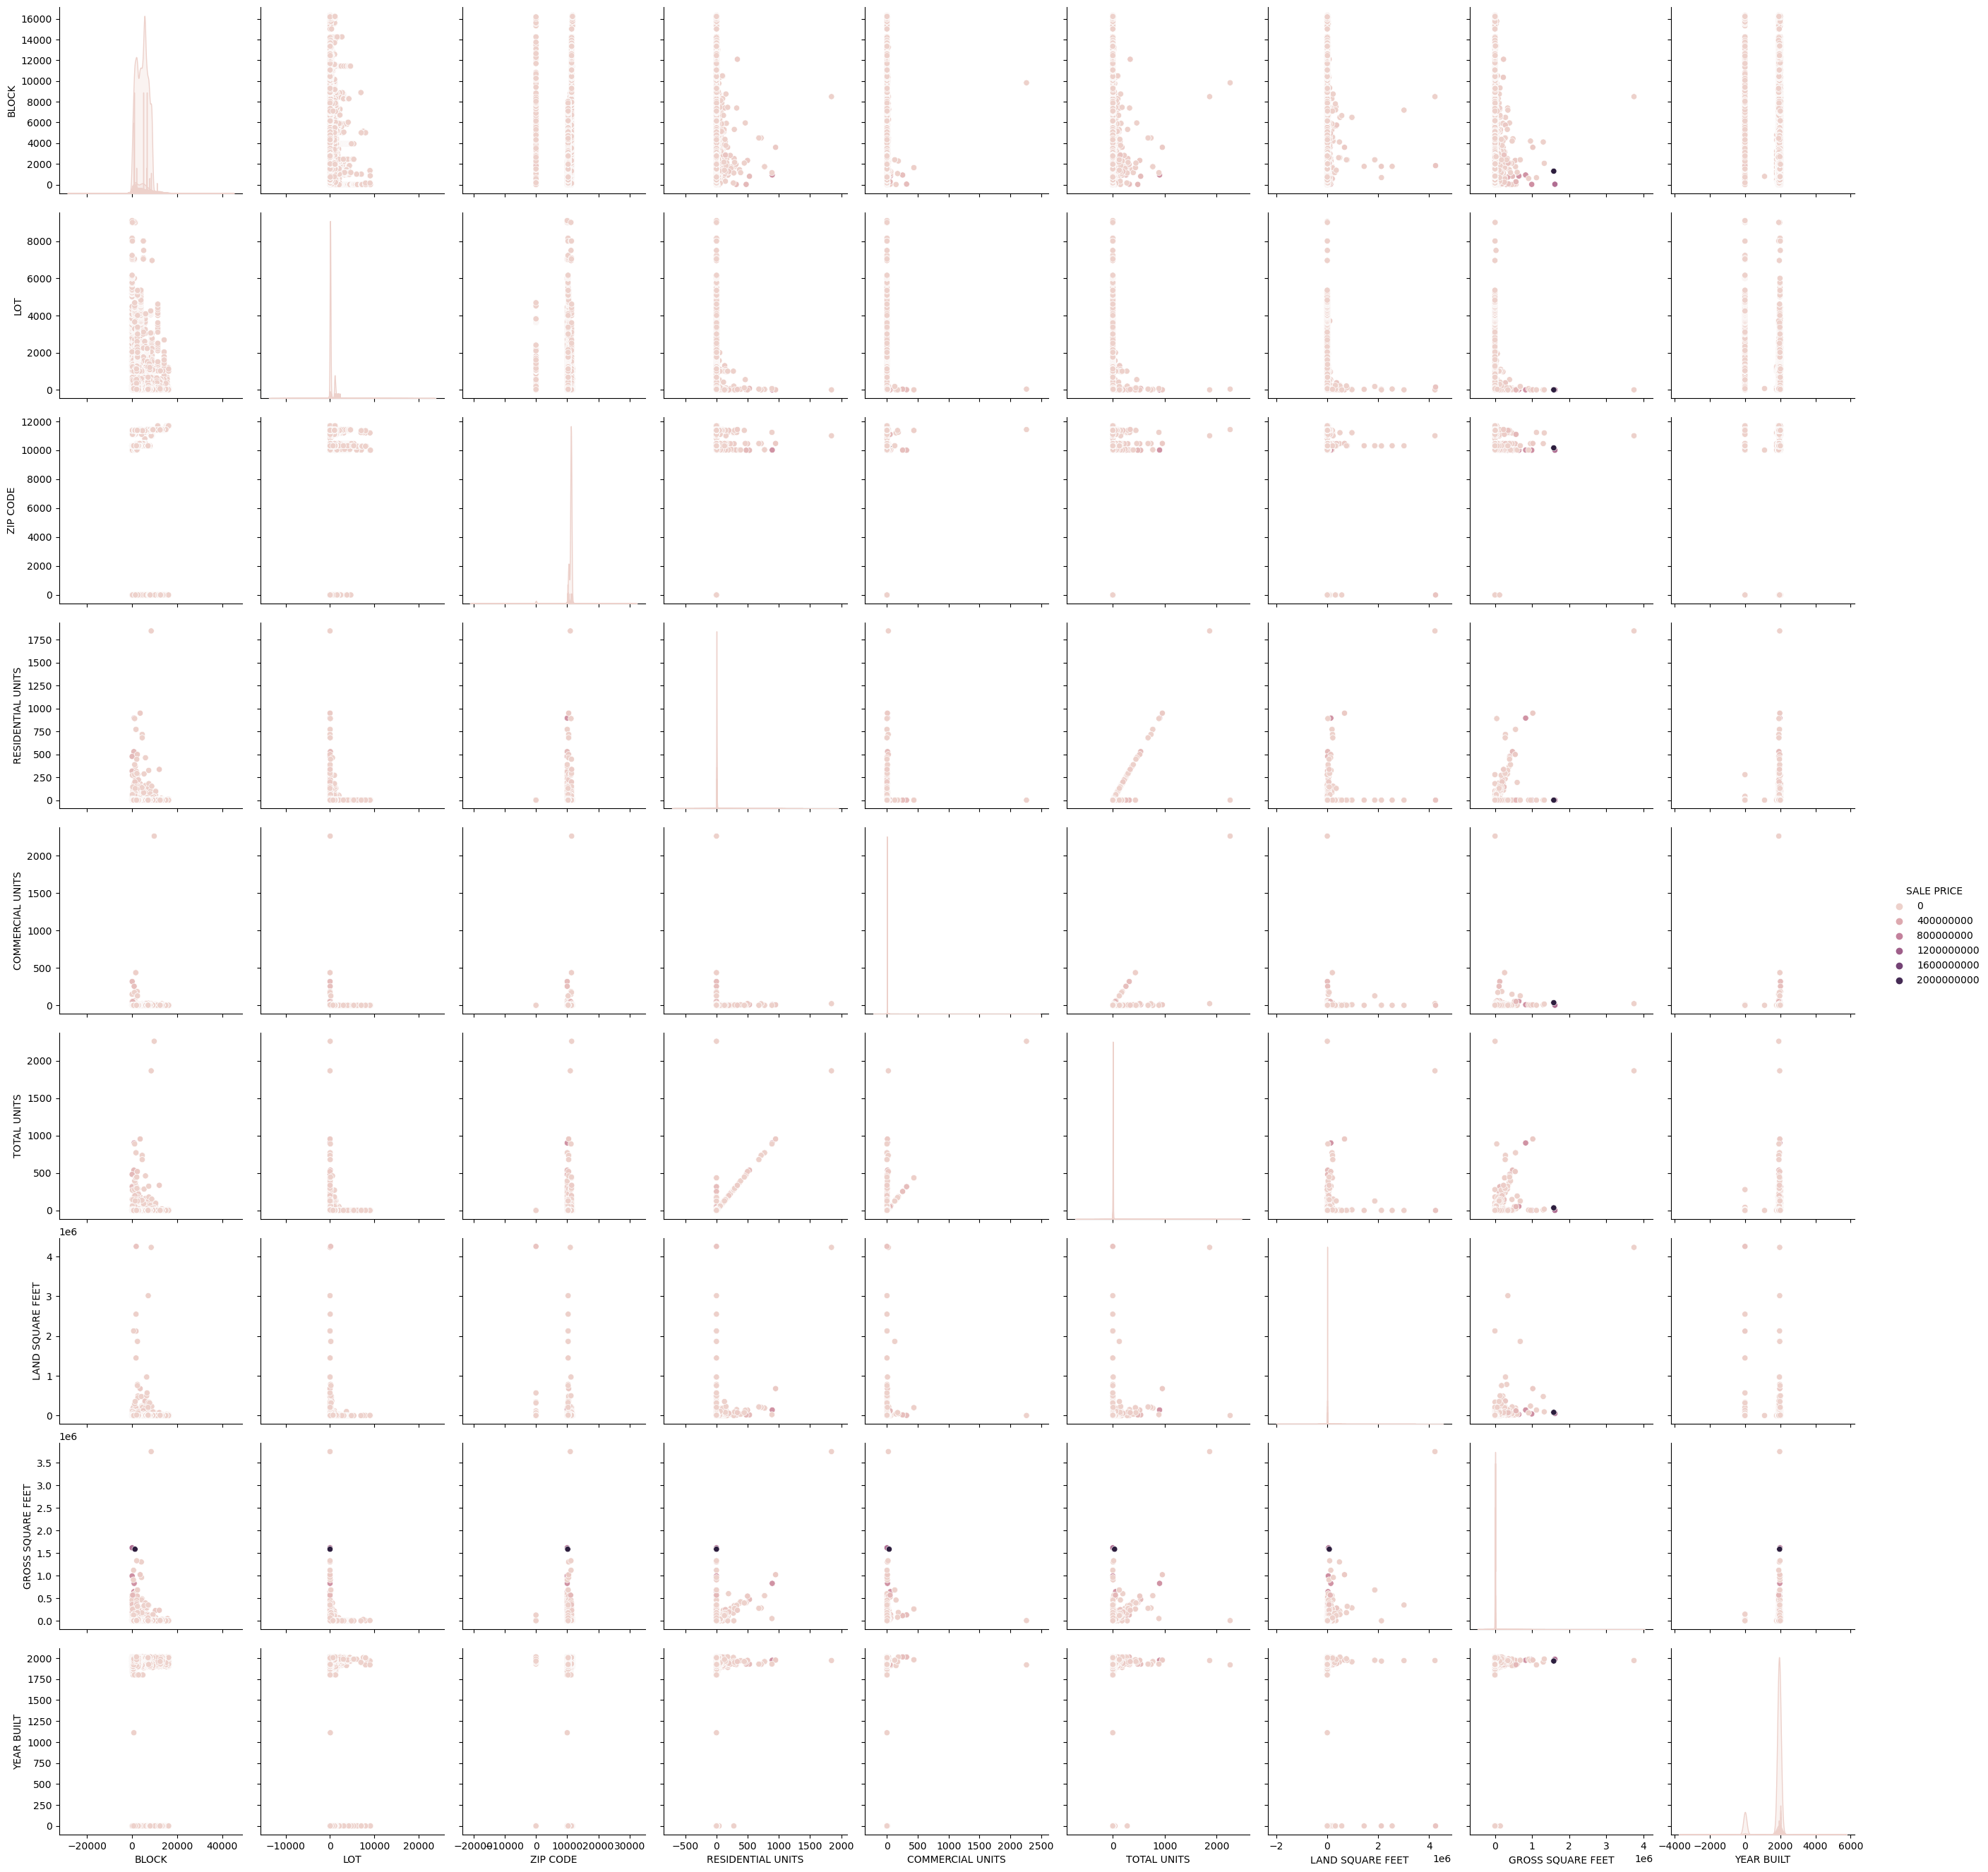

In [14]:
# Plot pairplot for data correlation and analysis of outliers
numerical_columns = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != 'SALE PRICE']

sns.pairplot(df, vars=numerical_columns, height=3, aspect=1, hue='SALE PRICE')
plt.show()